# AVO projections

This notebook shows all the steps to implement AVO projections in a routine quantitative interpretation workflow. Please refer to "Seismic Amplitude: An Interpreter's Handbook" (Simm & Bacon, Cambridge University Press, 2014) for a detailed discussion on AVO projections and the theory behind.

The data I use in this notebook comes (as usual) from the [Quantitative Seismic Interpretation book website](http://pangea.stanford.edu/researchgroups/srb/resources/books/quantitative-seismic-interpretation).

_Please note that this is work in progress; my intention is to better explain some of the key theoretical and practical aspects as I go along. However, everything seems to be working ok so I thought that other people may benefit from this._

## import libraries

The usual libraries are imported; note the use of [my version](https://github.com/aadm/geophysical_notes/blob/master/segypy.py) of `segypy` to load seismic data and [bruges](http://www.agilegeoscience.com/bruges/) from Agile Geoscience for reflectivity equations etc.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import segypy
import bruges as b
# from scipy.optimize import curve_fit
from scipy.interpolate import griddata

%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

## define a few functions

I will define here 4 functions to make the rest of the workflow smoother:

1. `vpvs`: to analyze Vp-Vs relationships and return an empirical relation to be applied on well with no Vs log available;
2. `wellplot`: to display well log suite nicely formatted etc;
3. `avoplot`: to calculate and display single interface AVO and Intercept-Gradient crossplots;
4. `avoproj`: to calculate and display "extended" AVO responses and identify optimal angles for lithology and fluid projections.

In [3]:
def vpvs(ww,vsh_cutoff,z1,z2):
    ss=(ww.VSH<=vsh_cutoff) & (ww.DEPTH>=z1) & (ww.DEPTH<=z2)
    sh=(ww.VSH>vsh_cutoff)  & (ww.DEPTH>=z1) & (ww.DEPTH<=z2)

    flagfrm=True if 'VP_FRMB' in ww.columns else False
    if flagfrm:
        vp_ss=ww.VP_FRMB[ss]
        vs_ss=ww.VS_FRMB[ss]
        vp_sh=ww.VP_FRMB[sh]
        vs_sh=ww.VS_FRMB[sh]
    else:
        vp_ss=ww.VP[ss]
        vs_ss=ww.VS[ss]
        vp_sh=ww.VP[sh]
        vs_sh=ww.VS[sh]

    x=np.linspace(1500,6000,100)
    par_ss = np.polyfit(vp_ss, vs_ss, 1)
    fit_y_ss = par_ss[0]*x+par_ss[1]
    par_sh = np.polyfit(vp_sh, vs_sh, 1)
    fit_y_sh = par_sh[0]*x+par_sh[1]

    lst = (-0.0551*(x/1e3)**2 + 1.016*(x/1e3) - 1.0305) * 1e3
    dol = 0.583*x - 78
    sst = 0.804*x - 856
    sh  = 0.769*x - 867

    plt.figure()
    plt.plot(vp_sh,vs_sh,'.g', alpha=0.5, label='sh', ms=5)
    plt.plot(vp_ss,vs_ss,'.k', alpha=0.5, label='sst', ms=5)
    plt.plot(x,fit_y_ss,'-k', lw=2, label='Vs (sst)=%.3f%+.3f*Vp' % (par_ss[1], par_ss[0]))
    plt.plot(x,fit_y_sh,'-g', lw=2, label='Vs (sh)=%.3f%+.3f*Vp' % (par_sh[1], par_sh[0]))
    plt.plot(x,lst,':r',label='G-C lst')
    plt.plot(x,sst,'-r',label='G-C sst')
    plt.plot(x,sh,'--r',label='G-C sh')
    plt.grid(), plt.xlabel('Vp'), plt.ylabel('Vs')
    plt.xlim(1000,6000), plt.ylim(500,3000)
    plt.legend(fontsize='small',loc='lower right')

    return par_ss, par_sh

In [4]:
def wellplot(WW,ztop=None,zbot=None,name=None,tops=None):
    '''
    wellplot (c) aadm 2015
    Simple logview plot.

    INPUT
    WW: Pandas dataframe with VP, [VS], RHO, IP, [VPVS or PR], [SWE], PHIE, VSH
    ztop,zbot: depth range to plot (defaults to min,max depth)
    name: well name (or anything else) to print
    tops: dictionary containing stratigraphic tops, defined as
        a dictionary (dict):
        tops={'Trias': 1200,'Permian': 2310}
        or a Pandas series

    HISTORY
    2015-10-01 added option to read tops (either as dict or Pandas series)
    2015-09-29 also accepts logset with no Vs
    2015-08-04 updated with depth range input
    2015-06-30 first version
    '''
    flagtops=False
    flagvs=True if 'VS' in WW.columns else False
    if isinstance(tops, pd.Series): # check if tops is a Pandas series
        tmp_tops=tops.to_dict()
        flagtops=True
    elif tops!=None: # then checks if tops exists (as a dict)
        tmp_tops=tops
        flagtops=True
    if ztop==None:
        ztop=WW.DEPTH.min()
    if zbot==None:
        zbot=WW.DEPTH.max()
    if flagvs:
        velmin=WW[(WW.DEPTH>=ztop) & (WW.DEPTH<=zbot)].ix[:,['VS']].min().values
    else:
        velmin=WW[(WW.DEPTH>=ztop) & (WW.DEPTH<=zbot)].ix[:,['VP']].min().values
    velmax=WW[(WW.DEPTH>=ztop) & (WW.DEPTH<=zbot)].ix[:,['VP']].max().values
    dmin=WW[(WW.DEPTH>=ztop) & (WW.DEPTH<=zbot)].ix[:,['RHO']].min().values
    dmax=WW[(WW.DEPTH>=ztop) & (WW.DEPTH<=zbot)].ix[:,['RHO']].max().values
    ipmin=WW[(WW.DEPTH>=ztop) & (WW.DEPTH<=zbot)].ix[:,['IP']].min().values
    ipmax=WW[(WW.DEPTH>=ztop) & (WW.DEPTH<=zbot)].ix[:,['IP']].max().values
    rmin=WW[(WW.DEPTH>=ztop) & (WW.DEPTH<=zbot)].ix[:,['VPVS']].min().values
    rmax=WW[(WW.DEPTH>=ztop) & (WW.DEPTH<=zbot)].ix[:,['VPVS']].max().values

    f, ax = plt.subplots(nrows=1,ncols=5,sharey=True,figsize=(12,10),facecolor='w')
    if 'SWE' in WW.columns:
        ax[0].plot(WW.SWE, WW.DEPTH, color='blue', alpha=0.8, lw=1, label='Swe')
    ax[0].plot(WW.VSH, WW.DEPTH, color='chocolate', alpha=0.8, lw=1, label='Vsh')
    ax[0].plot(WW.PHIE, WW.DEPTH, color='black', alpha=0.8, lw=1, label='phie')
    ax[1].plot(WW.VP, WW.DEPTH, 'k', lw=1, label='Vp')
    if flagvs:
        ax[1].plot(WW.VS, WW.DEPTH, color='lightsteelblue', lw=1, label='Vs')
    ax[2].plot(WW.RHO, WW.DEPTH, 'k', lw=1)
    ax[3].plot(WW.IP, WW.DEPTH, 'k', lw=1)
    if flagvs:
        if 'PR' in WW.columns:
            ax[4].plot(WW.PR, WW.DEPTH, 'k', lw=1)
            ax[4].set_xlabel('PR'), ax[4].set_xlim(0.0,0.5)
        else:
            ax[4].plot(WW.VPVS, WW.DEPTH, 'k', lw=1)
            ax[4].set_xlabel('Vp/Vs'), ax[4].set_xlim(rmin-rmin*.01,rmax+rmax*.01)
    else:
        ax[4].text(2.5, (zbot-ztop)/2+ztop, 'no Vs', fontsize=14,horizontalalignment='center')
        ax[4].set_xlim(0,5)
        ax[4].set_xticklabels([])
    ax[0].set_xlabel('Vcl/Sw/phi'),     ax[0].set_xlim(-0.1,1.1),                          ax[0].set_ylim(ztop,zbot)
    ax[1].set_xlabel('Velocity (m/s)'), ax[1].set_xlim(velmin-velmin*.1,velmax+velmax*.1), ax[1].set_ylim(ztop,zbot)
    ax[2].set_xlabel('Density (g/cc)'), ax[2].set_xlim(dmin-dmin*.01,dmax+dmax*.01),       ax[2].set_ylim(ztop,zbot)
    ax[3].set_xlabel('Ip (m/s*g/cc)'),  ax[3].set_xlim(ipmin-ipmin*.1,ipmax+ipmax*.1),     ax[3].set_ylim(ztop,zbot)
    ax[0].set_ylim(zbot,ztop)
    ax[0].legend(fontsize=8, loc='lower right')
    ax[1].legend(fontsize=8, loc='lower right')
    for aa in ax.flatten():
        aa.grid()
        aa.xaxis.tick_top()
        plt.setp(aa.xaxis.get_majorticklabels(), rotation=90, fontsize=8)
        if flagtops:
            for topz in tmp_tops.values():
                if ~np.isnan(topz):
                    aa.axhline( y = float(topz), color='gold', lw=2,alpha=0.5,xmin=0.05,xmax=0.95)
    if flagtops:
        for topn, topz in tmp_tops.iteritems():
            if (~np.isnan(topz)) & (topz>=ztop) & (topz<=zbot):
                ax[0].text(x=min(ax[0].xaxis.get_data_interval())*1.0,
                       y=float(topz),s=topn,alpha=0.75,color='k',fontsize=10,ha='left',va='center',
                                 bbox=dict(facecolor='white', alpha=1.0, lw = 0.25),
                                 weight = 'light')
    if name!=None:
        plt.suptitle(name, fontsize=14)

In [5]:
def avoplot(WW, top, above, below, res='down', name=None):
    '''
    avoplot (c) aadm 2015
    AVO and Intercept-Gradient crossplots.

    INPUT
    WW: Pandas dataframe with GR, VP, VS, RHO
    top: interface for AVO calculations
    above,below: meters above/below interface to calculate average elastic properties
    res: 'up' or 'down', specifies where reservoir (and associated fluid changes) is located
    name: well name (or anything else) to print

    HISTORY
    2015-11-10 added possibility to specify whether reservoir is the upper or lower layer
    2015-10-02 first version
    '''
    flagfrm=True if 'VP_FRMB' in WW.columns else False
    from bruges.reflection import akirichards, shuey2
    mx = 0.4
    ang=np.linspace(0,40,41)
    z=WW.DEPTH
    up=(WW.DEPTH>=top-above) & (WW.DEPTH<=top)
    lo=(WW.DEPTH>=top)       & (WW.DEPTH<=top+below)
    plotmax=WW[(WW.DEPTH>=top-above*2) & (WW.DEPTH<=top+below*2)][['GR','IP']].max().values
    plotmin=WW[(WW.DEPTH>=top-above*2) & (WW.DEPTH<=top+below*2)][['GR','IP']].min().values
    el0=np.array([
              [np.nanmean(WW.VP[up]), np.nanmean(WW.VS[up]), np.nanmean(WW.RHO[up])],
              [np.nanmean(WW.VP[lo]), np.nanmean(WW.VS[lo]), np.nanmean(WW.RHO[lo])] ])
    print('... [upper layer] Vp:%8.2f, Vs:%8.2f, rho:%8.4f, Ip: %8.2f, Vp/Vs:%5.2f' % (el0[0,0],el0[0,1],el0[0,2],el0[0,0]*el0[0,2],el0[0,0]/el0[0,1]))
    print('... [lower layer] Vp:%8.2f, Vs:%8.2f, rho:%8.4f, Ip: %8.2f, Vp/Vs:%5.2f' % (el0[1,0],el0[1,1],el0[1,2],el0[1,0]*el0[1,2],el0[1,0]/el0[1,1]))
    rc     = akirichards(el0[0,0],el0[0,1],el0[0,2],el0[1,0],el0[1,1],el0[1,2],ang)
    tmp    = shuey2(el0[0,0],el0[0,1],el0[0,2],el0[1,0],el0[1,1],el0[1,2],30,terms=True)
    I      = tmp[0]
    G      = tmp[1] / np.sin(np.radians(30))**2

    if flagfrm:
        if res=='up':
            el1=np.array([
                      [np.nanmean(WW.VP_FRMB[up]), np.nanmean(WW.VS_FRMB[up]), np.nanmean(WW.RHO_FRMB[up])],
                      [np.nanmean(WW.VP_FRMO[up]), np.nanmean(WW.VS_FRMO[up]), np.nanmean(WW.RHO_FRMO[up])],
                      [np.nanmean(WW.VP_FRMG[up]), np.nanmean(WW.VS_FRMG[up]), np.nanmean(WW.RHO_FRMG[up])] ])

            rc_bri = akirichards(el1[0,0],el1[0,1],el1[0,2],el0[1,0],el0[1,1],el0[1,2],ang)
            tmp    =      shuey2(el1[0,0],el1[0,1],el1[0,2],el0[1,0],el0[1,1],el0[1,2],30,terms=True)
            I_bri  = tmp[0]
            G_bri  = tmp[1] / np.sin(np.deg2rad(30))**2

            rc_oil = akirichards(el1[1,0],el1[1,1],el1[1,2],el0[1,0],el0[1,1],el0[1,2],ang)
            tmp    =      shuey2(el1[1,0],el1[1,1],el1[1,2],el0[1,0],el0[1,1],el0[1,2],30,terms=True)
            I_oil  = tmp[0]
            G_oil  = tmp[1] / np.sin(np.deg2rad(30))**2

            rc_gas = akirichards(el1[2,0],el1[2,1],el1[2,2],el0[1,0],el0[1,1],el0[1,2],ang)
            tmp    =      shuey2(el1[2,0],el1[2,1],el1[2,2],el0[1,0],el0[1,1],el0[1,2],30,terms=True)
            I_gas  = tmp[0]
            G_gas  = tmp[1] / np.sin(np.deg2rad(30))**2
            bb='upper layer'
        else:
            el1=np.array([
                        [np.nanmean(WW.VP_FRMB[lo]), np.nanmean(WW.VS_FRMB[lo]), np.nanmean(WW.RHO_FRMB[lo])],
                        [np.nanmean(WW.VP_FRMO[lo]), np.nanmean(WW.VS_FRMO[lo]), np.nanmean(WW.RHO_FRMO[lo])],
                        [np.nanmean(WW.VP_FRMG[lo]), np.nanmean(WW.VS_FRMG[lo]), np.nanmean(WW.RHO_FRMG[lo])] ])
            rc_bri = akirichards(el0[0,0],el0[0,1],el0[0,2],el1[0,0],el1[0,1],el1[0,2],ang)
            tmp    =      shuey2(el0[0,0],el0[0,1],el0[0,2],el1[0,0],el1[0,1],el1[0,2],30,terms=True)
            I_bri  = tmp[0]
            G_bri  = tmp[1] / np.sin(np.deg2rad(30))**2

            rc_oil = akirichards(el0[0,0],el0[0,1],el0[0,2],el1[1,0],el1[1,1],el1[1,2],ang)
            tmp    =      shuey2(el0[0,0],el0[0,1],el0[0,2],el1[1,0],el1[1,1],el1[1,2],30,terms=True)
            I_oil  = tmp[0]
            G_oil  = tmp[1] / np.sin(np.deg2rad(30))**2

            rc_gas = akirichards(el0[0,0],el0[0,1],el0[0,2],el1[2,0],el1[2,1],el1[2,2],ang)
            tmp    =      shuey2(el0[0,0],el0[0,1],el0[0,2],el1[2,0],el1[2,1],el1[2,2],30,terms=True)
            I_gas  = tmp[0]
            G_gas  = tmp[1] / np.sin(np.deg2rad(30))**2
            bb='lower layer'
        print('... [%s] Vp:%8.2f, Vs:%8.2f, rho:%8.2f, Ip: %8.2f, Vp/Vs:%5.2f --> BRINE' % (bb,el1[0,0],el1[0,1],el1[0,2],el1[0,0]*el1[0,2],el1[0,0]/el1[0,1]))
        print('... [%s] Vp:%8.2f, Vs:%8.2f, rho:%8.2f, Ip: %8.2f, Vp/Vs:%5.2f --> OIL'   % (bb,el1[1,0],el1[1,1],el1[1,2],el1[1,0]*el1[1,2],el1[1,0]/el1[1,1]))
        print('... [%s] Vp:%8.2f, Vs:%8.2f, rho:%8.2f, Ip: %8.2f, Vp/Vs:%5.2f --> GAS'   % (bb,el1[2,0],el1[2,1],el1[2,2],el1[2,0]*el1[2,2],el1[2,0]/el1[2,1]))

    f=plt.subplots(figsize=(12, 6),facecolor='w')
    ax0 = plt.subplot2grid((1,6), (0,0), colspan=1)
    ax1 = plt.subplot2grid((1,6), (0,1), colspan=1)
    ax2 = plt.subplot2grid((1,6), (0,2), colspan=2)
    ax3 = plt.subplot2grid((1,6), (0,4), colspan=2)
    ax0.plot(WW.GR,WW.DEPTH,'-k')
    ax0.set_xlabel('GR'), ax0.set_xlim(0,plotmax[0]+plotmax[0]*.2)
    ax0.set_ylim(top-(above*2),top+(below*2))
    ax0.plot((6, 6), (top-above, top+below), 'c', lw=6, alpha=0.5)
    if flagfrm:
        ax1.plot(WW.VP_FRMB*WW.RHO_FRMB, WW.DEPTH, 'b')
        ax1.plot(WW.VP_FRMO*WW.RHO_FRMO, WW.DEPTH, 'g')
        ax1.plot(WW.VP_FRMG*WW.RHO_FRMG, WW.DEPTH, 'r')
    ax1.plot(WW.IP,WW.DEPTH,'-k')
    ax1.set_yticklabels([])
    ax1.set_xlabel('Ip (m/s*g/cc)'), ax1.set_xlim(plotmin[1]-plotmin[1]*.2,plotmax[1]+plotmax[1]*.2)
    ax1.set_ylim(top-(above*2),top+(below*2))
    for aa in [ax0, ax1]:
        aa.invert_yaxis()
        aa.grid()
        aa.xaxis.tick_top()
        plt.setp(aa.xaxis.get_majorticklabels(), rotation=90, fontsize=8)
        aa.axhline(y=top,color='gold',lw=2,alpha=0.5)
    ax2.plot(ang, rc,'-k', lw=4, label=str(top)+' m')
    # ax2.plot(ang, rc[1], '--k',  lw=2, label='Top +anis')
    if flagfrm:
        ax2.plot(ang, rc_bri, '-b',lw=2, label='brine')
        ax2.plot(ang, rc_oil, '-g',lw=2, label='oil')
        ax2.plot(ang, rc_gas, '-r',lw=2, label='gas')
    ax2.axhline(0,color='k',lw=2)
    ax2.set_xlabel('angle of incidence')
    ax2.legend(loc='lower right', fontsize='small')
    if flagfrm:
        ax3.plot(I_bri, G_bri, 'bo', ms=10, mec='b')
        ax3.plot(I_oil, G_oil, 'go', ms=10, mec='g')
        ax3.plot(I_gas, G_gas, 'ro', ms=10, mec='r')
    ax3.plot(I,G,'ko',ms=10,mfc='none',mew=2)
    ax3.axhline(0, color='k', lw=2), ax3.axvline(0, color='k', lw=2)
    ax3.set_xlim(-mx, mx)
    ax3.xaxis.set_label_position('top'), ax3.xaxis.tick_top()
    ax3.yaxis.set_label_position('right'), ax3.yaxis.tick_right()
    ax3.set_xlabel('intercept'), ax3.set_ylabel('gradient')
    for bb in [ax2, ax3]:
        bb.grid()
        bb.tick_params(axis='both', which='major', labelsize=8)
        bb.set_ylim(-mx, mx)
    if name!=None:
        plt.suptitle(name, fontsize=16, y=0.05, x=0.95, ha='right')

In [6]:
def avoproj(WW, top, above, below, name=None, fluid='gas'):
    '''
    avoproj (c) aadm 2015
    AVO projections.

    INPUT
    WW: Pandas dataframe with GR, VP, VS, RHO
    top: interface for AVO calculations
    above,below: meters above/below interface to calculate average elastic properties
    name: well name (or anything else) to print
    fluid: select either gas or oil to determine best angle to maximise fluid separation

    HISTORY
    2015-11-06 removed I-G plot
    2015-10-21 first version
    '''
    from bruges.reflection import shuey2
    ang=np.linspace(0,30)
    angl=np.sin(np.deg2rad(ang))**2
    chi=np.deg2rad(np.arange(-180,185,5))
    if fluid == 'oil':
        print '==> AVO projections to maximise brine-oil separation'
    elif fluid == 'gas':
        print '==> AVO projections to maximise brine-gas separation'
    else:
        print '==> please choose either gas or oil!'
        return
    z=WW.DEPTH
    up=(WW.DEPTH>=top-above) & (WW.DEPTH<=top)
    lo=(WW.DEPTH>=top)       & (WW.DEPTH<=top+below)
    el=np.array([ [np.nanmean(WW.VP[up]), np.nanmean(WW.VS[up]), np.nanmean(WW.RHO[up])],
              [np.nanmean(WW.VP[lo]), np.nanmean(WW.VS[lo]), np.nanmean(WW.RHO[lo])],
              [np.nanmean(WW.VP_FRMB[lo]), np.nanmean(WW.VS_FRMB[lo]), np.nanmean(WW.RHO_FRMB[lo])],
              [np.nanmean(WW.VP_FRMO[lo]), np.nanmean(WW.VS_FRMO[lo]), np.nanmean(WW.RHO_FRMO[lo])],
              [np.nanmean(WW.VP_FRMG[lo]), np.nanmean(WW.VS_FRMG[lo]), np.nanmean(WW.RHO_FRMG[lo])] ])
    rc_bri = shuey2(el[0,0],el[0,1],el[0,2],el[2,0],el[2,1],el[2,2],ang,terms=True)
    rc_oil = shuey2(el[0,0],el[0,1],el[0,2],el[3,0],el[3,1],el[3,2],ang,terms=True)
    rc_gas = shuey2(el[0,0],el[0,1],el[0,2],el[4,0],el[4,1],el[4,2],ang,terms=True)
    G_bri=rc_bri[1][-1]/angl[-1]
    G_oil=rc_oil[1][-1]/angl[-1]
    G_gas=rc_gas[1][-1]/angl[-1]
    # modified Shuey's equations
    rc_bri_m  = rc_bri[0]*np.cos(chi)+G_bri*np.sin(chi)
    rc_oil_m  = rc_oil[0]*np.cos(chi)+G_oil*np.sin(chi)
    rc_gas_m  = rc_gas[0]*np.cos(chi)+G_gas*np.sin(chi)
    # calculates angle where distance brine-oil/gas is maximised/minimised
    if fluid == 'oil':
        idl=np.argmin(np.abs((rc_bri_m)-(rc_oil_m)))
        idf=np.argmax(np.abs((rc_bri_m)-(rc_oil_m)))
    else:
        idl=np.argmin(np.abs((rc_bri_m)-(rc_gas_m)))
        idf=np.argmax(np.abs((rc_bri_m)-(rc_gas_m)))
    # do the plot
    plt.figure(figsize=(6,6),facecolor='w')
    plt.axhline(0,color='k',lw=2), plt.axvline(0,color='k',lw=2)
    plt.plot(np.rad2deg(chi), rc_bri_m,'-b',lw=2)
    plt.plot(np.rad2deg(chi), rc_oil_m,'-g',lw=2)
    plt.plot(np.rad2deg(chi), rc_gas_m,'-r',lw=2)
    plt.axvline(np.rad2deg(chi[idl]), color='m',label=r'$\mathrm{litho}\; \chi=%+.0f^\circ$' % np.rad2deg(chi[idl]))
    plt.axvline(np.rad2deg(chi[idf]), color='c',label=r'$\mathrm{fluid}\; \chi=%+.0f^\circ$' % np.rad2deg(chi[idf]))
    plt.xlabel(r'$\chi$')
    plt.legend()
    plt.grid()
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.xticks(np.arange(-180,190,40))
    plt.xlim(-180, 180), plt.ylim(-.5, .5)
    if name!=None:
        plt.suptitle(name, fontsize=16, y=0.05, x=0.95, ha='right')

## step 1: load well data and do AVO at selected level

In [7]:
w2=pd.read_csv('qsiwell2_frm.csv')
w2.rename(columns={'PHI':'PHIE'}, inplace=True)
w2.rename(columns={'SW':'SWE'}, inplace=True)

Vp-Vs relations:
sand: Vs = 0.829*Vp -1034.563
shale: Vs = 0.689*Vp -677.156


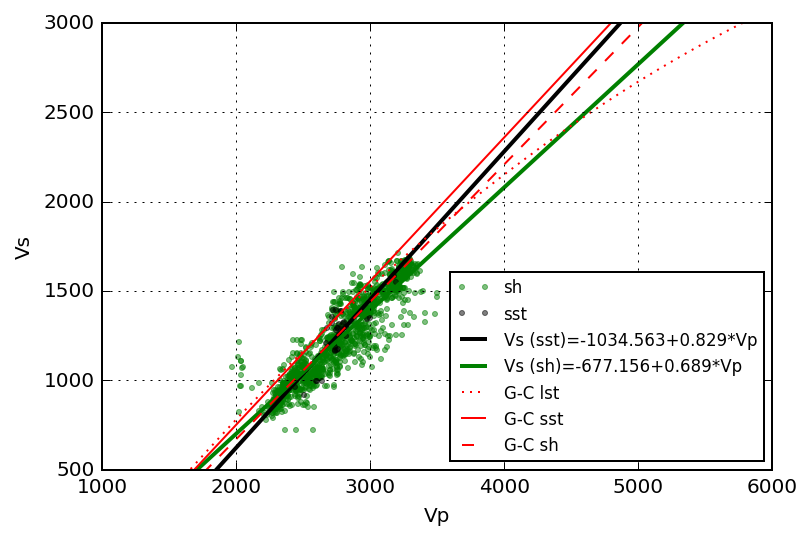

In [8]:
par_ss,par_sh=vpvs(w2,0.1,2100,2300)

print "Vp-Vs relations:"
print "sand: Vs = {:0.3f}*Vp {:+0.3f}".format(par_ss[0],par_ss[1])
print "shale: Vs = {:0.3f}*Vp {:+0.3f}".format(par_sh[0],par_sh[1])

In the following code I load data from well 3 (where no shear wave sonic log has been acquired), calculate shale volume and porosity(*) logs, then apply the empirical Vp-Vs relation from the previous step to calculate a Vs log and its derivates: Vp/Vs and shear impedance Is.

***
(*) 
<i>The porosity log is not really used in this workflow except for display purposes (it is  required from my `wellplot` function). A larger discussion on well log data analysis in Python can be found [in this other notebook](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_petrophysics.ipynb).
</i>

In [9]:
rho_qz=2.65;  k_qz=37;  mu_qz=44
rho_sh=2.81;  k_sh=15;  mu_sh=5
rho_w=1.09;   k_w=2.8
rho_o=0.78;   k_o=0.94 # # oil gravity: 32 API, GOR:    64

# quick petrophysical log calculation for Well 3
# and Vs calculation though empirical relation
w3raw=pd.read_table('well_3.txt', sep='\s+', header=None, skiprows=1, names=['DEPTH','VP','RHO','GR'])
w3raw.VP=w3raw.VP*1000

w3raw['VSH']=(w3raw.GR-w3raw.GR.min())/(w3raw.GR.max()-w3raw.GR.min())
w3raw['RHOm']=w3raw.VSH*rho_sh + (1-w3raw.VSH)*rho_qz
w3raw['RHOf']=np.ones(w3raw.DEPTH.size)*rho_w
w3raw['PHIE']= (w3raw.RHOm-w3raw.RHO) / ( w3raw.RHOm- w3raw.RHOf)
# compute Vs ...
vs_sst=par_ss[0]*w3raw.VP+par_ss[1]
vs=par_sh[0]*w3raw.VP+par_sh[1]
vs[w3raw.VSH<0.3]=vs_sst[w3raw.VSH<=0.3]

w3raw['VS']=vs
w3raw['VPVS']=w3raw.VP/w3raw.VS
w3raw['IP']=w3raw.VP*w3raw.RHO
w3raw['IS']=w3raw.VS*w3raw.RHO
w3=w3raw.copy()

Now I will take a look at the well data (using the `wellplot` function previously defined):

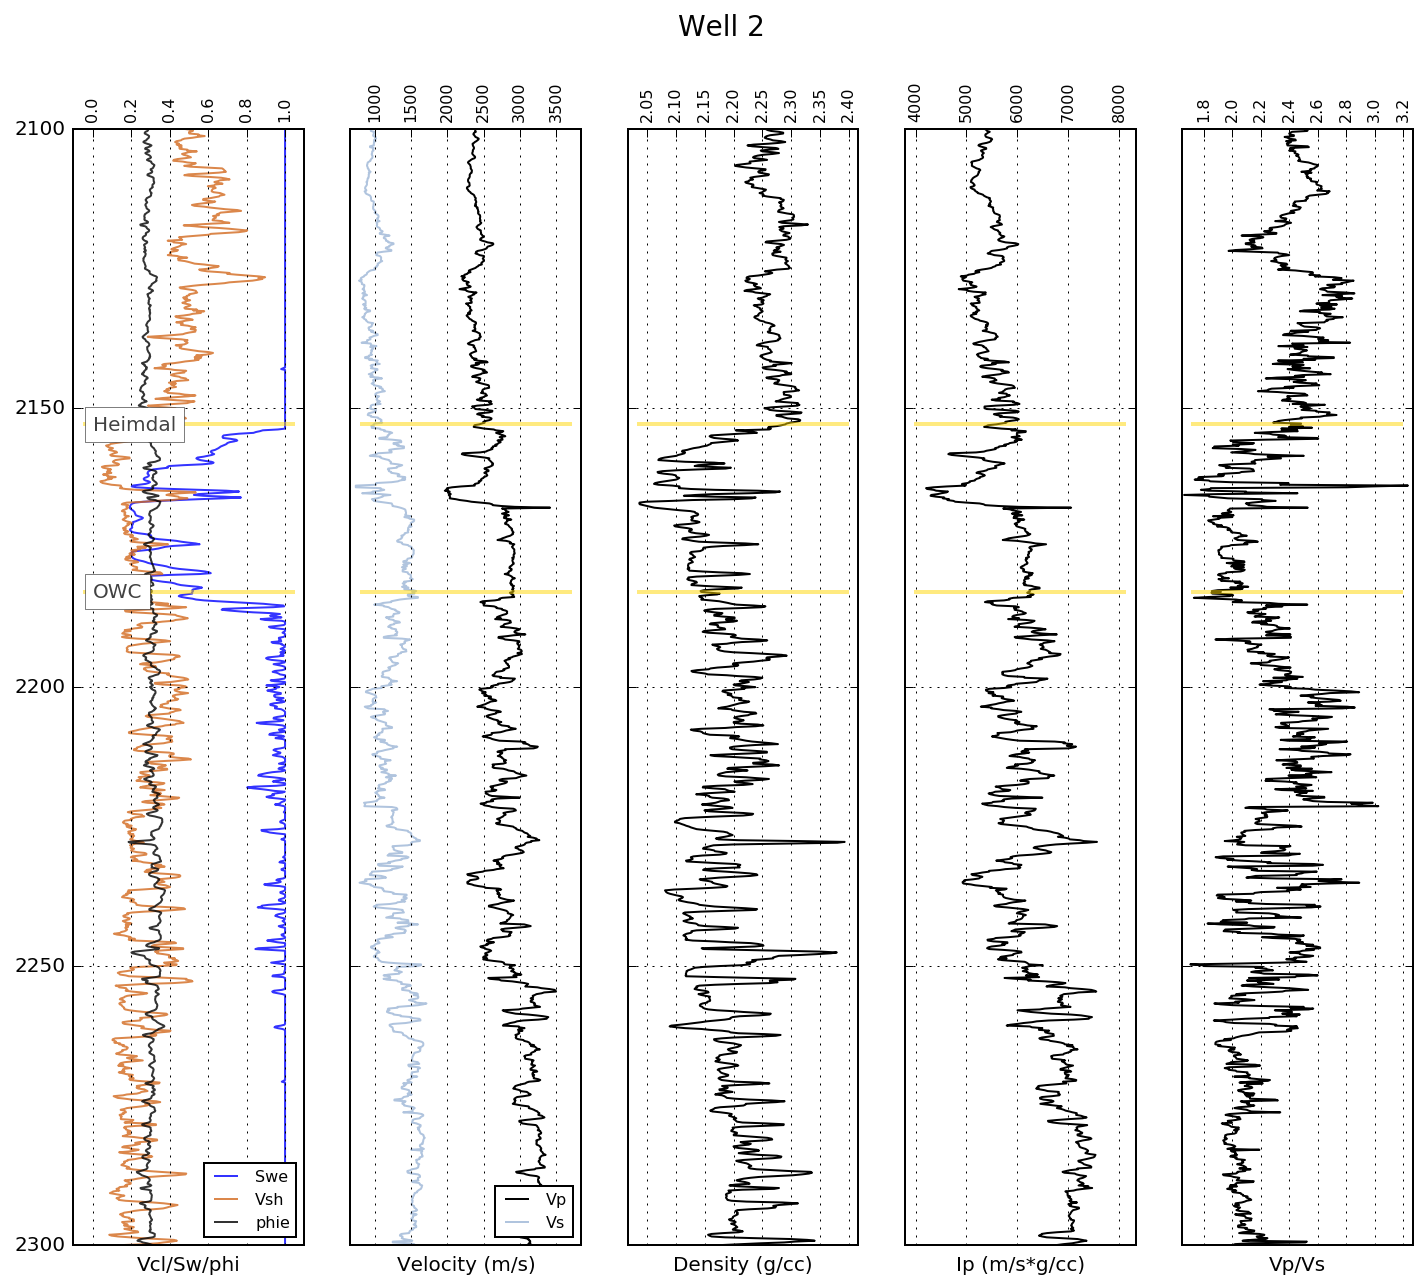

In [10]:
tops_w2={'Heimdal': 2153,'OWC': 2183}
wellplot(w2,ztop=2100,zbot=2300,name='Well 2',tops=tops_w2)

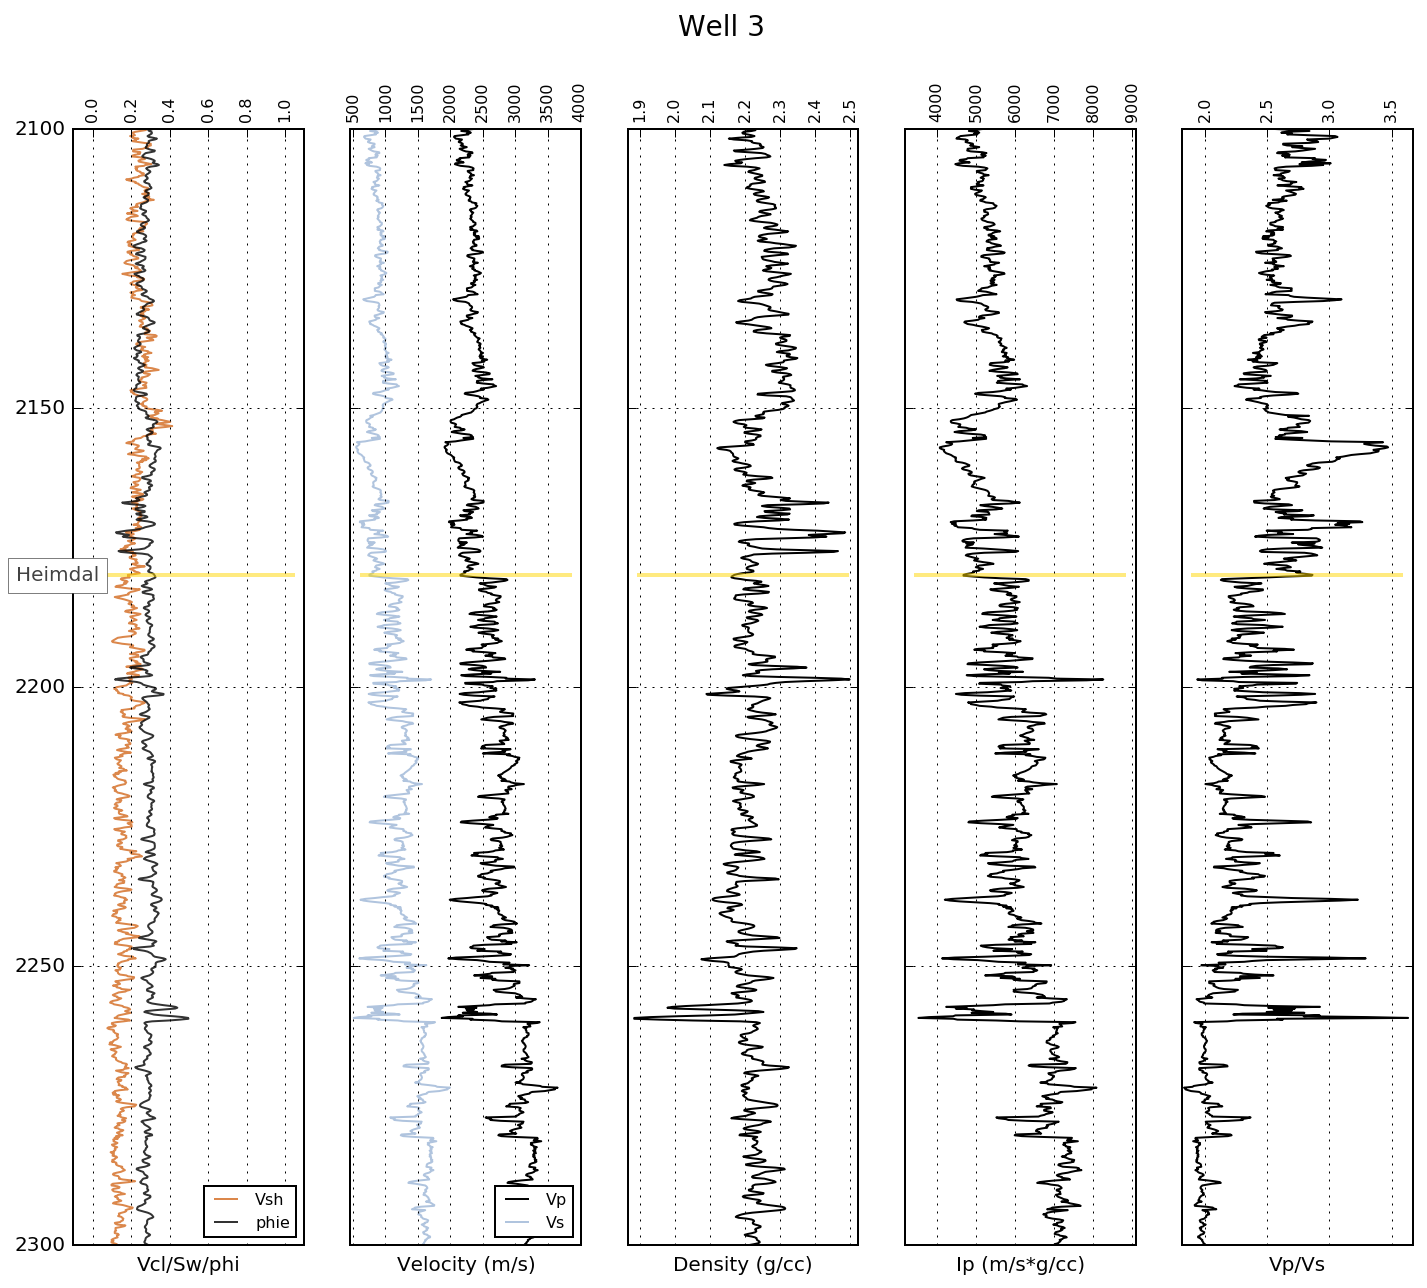

In [11]:
tops_w3={'Heimdal': 2180}
wellplot(w3,ztop=2100,zbot=2300,name='Well 3',tops=tops_w3)

The AVO signature at Top Heimdal on both wells can be calculated with `avoplot`, which is called with these parameters:

    avoplot(well_DataFrame, top, above, below, [name])
    
The function will calculate the amplitude variation with angles of incidence at the interface found at `top` meters of depth, using as elastic properties for the half-space above this interface the average Vp, Vs and density calculated between `top` and `top-above` meters, and for the half-space below the average over `top` and `top`+`below`.

The functions outputs a plot composed of gamma-ray (`GR`) and acoustic impedance (`Ip`) logs, and the AVO signatures in the angle of incidence versus reflectivity and in the Intercept versus Gradient domains. If fluid replaced logs are available, the function will also draw brine, oil and gas Ip logs as well as their AVO signatures.

Averages of the elastic properties for the two half-spaces are also output to the console.

Well 2:
... [upper layer] Vp: 2448.04, Vs:  983.62, rho:  2.2660, Ip:  5547.36, Vp/Vs: 2.49
... [lower layer] Vp: 2516.67, Vs: 1234.28, rho:  2.1221, Ip:  5340.73, Vp/Vs: 2.04
... [lower layer] Vp: 2662.86, Vs: 1219.41, rho:    2.17, Ip:  5785.08, Vp/Vs: 2.18 --> BRINE
... [lower layer] Vp: 2484.27, Vs: 1243.74, rho:    2.09, Ip:  5193.41, Vp/Vs: 2.00 --> OIL
... [lower layer] Vp: 2434.12, Vs: 1289.61, rho:    1.95, Ip:  4747.36, Vp/Vs: 1.89 --> GAS
Well 3:
... [upper layer] Vp: 2209.76, Vs:  805.83, rho:  2.2408, Ip:  4951.66, Vp/Vs: 2.74
... [lower layer] Vp: 2606.93, Vs: 1126.67, rho:  2.2302, Ip:  5814.03, Vp/Vs: 2.31


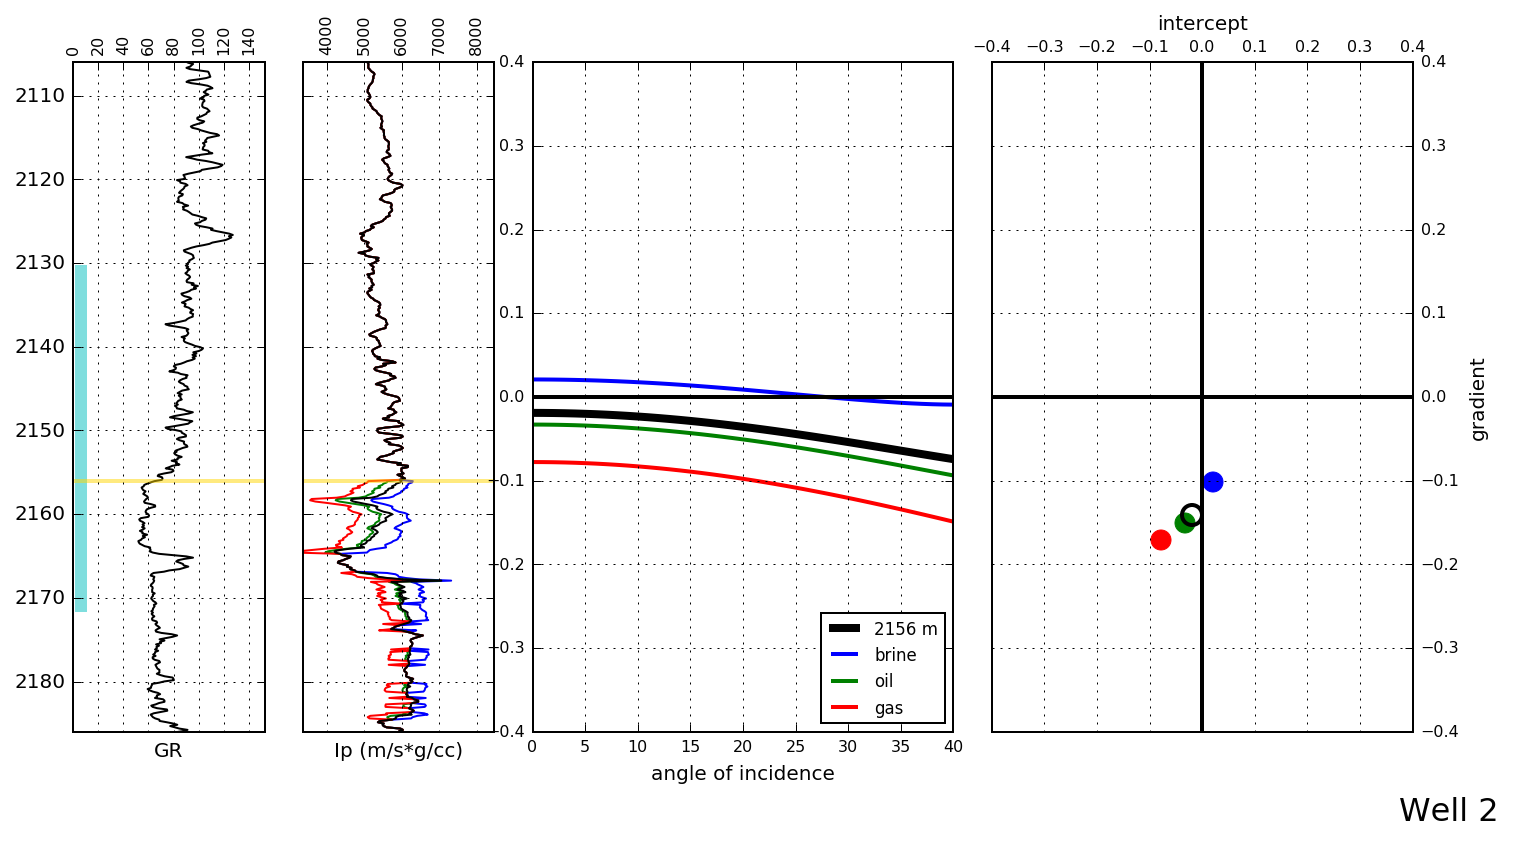

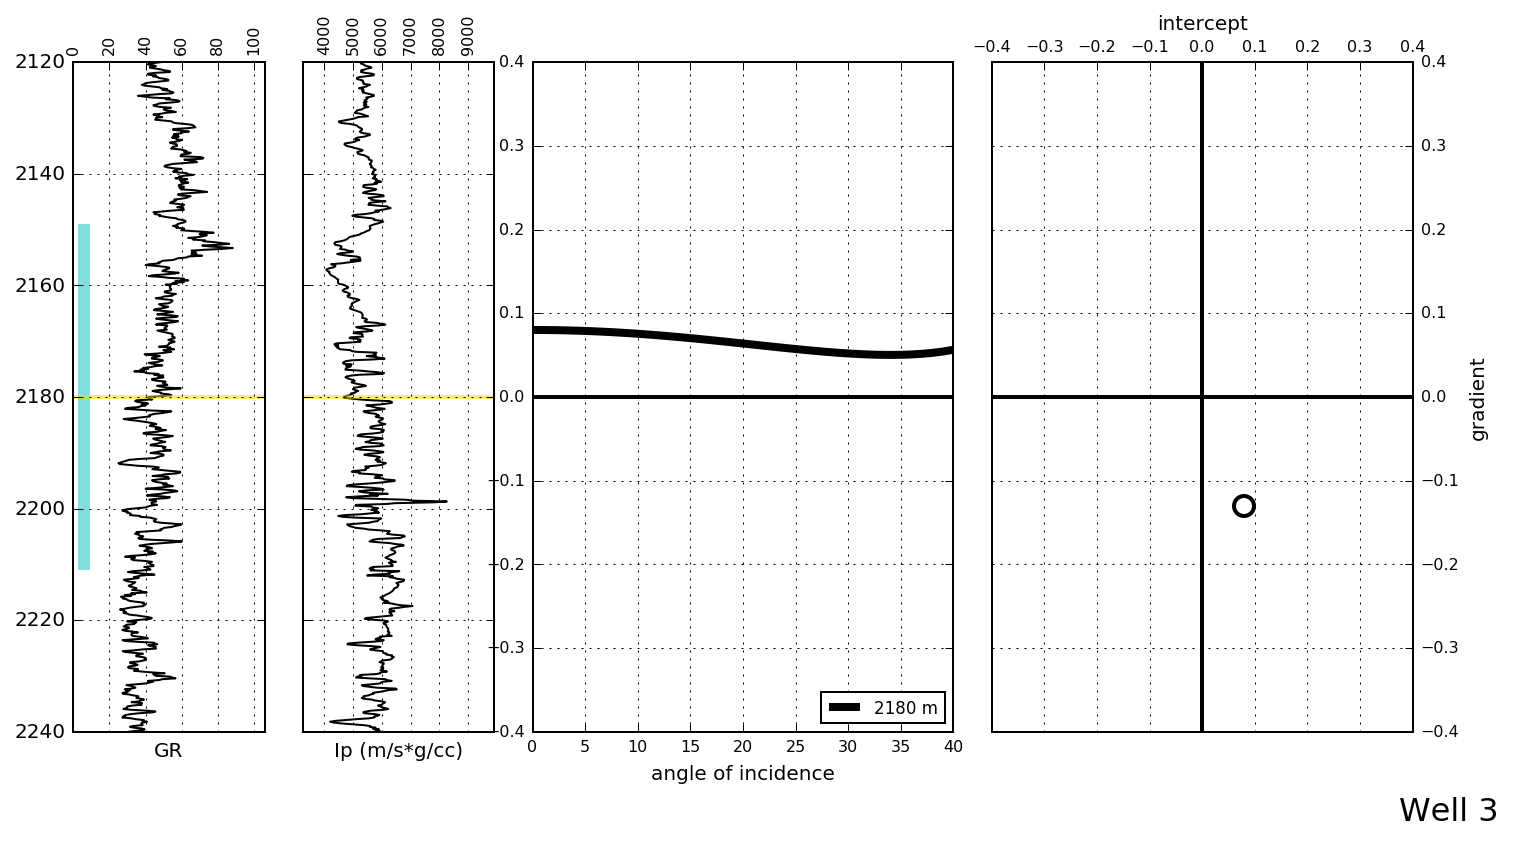

In [12]:
print 'Well 2:'
avoplot(w2,2156,25,15,name='Well 2')

print 'Well 3:'
avoplot(w3,2180,30,30,name='Well 3')

The result is that well 2 and 3 have different AVO responses at Top Heimdal. The best thing to do would be fluid replacement on well 3 and understand if the AVO response we have here is affected by the fluid (I don't even remember now if well 3 is supposed to be dry or oil-bearing; remember this was just an exercise for me so relax!). If for example the Heimdal sand is brine-bearing then, if we do fluid substitution to oil we may have a drastic reduction in Ip and Vp/Vs ratio and a similar AVO response to well 2 in similar fluid conditions (i.e., oil). 

Anyway, let's move on and calculate AVO projection plots, to determine the projection angles to optimise fluid separation. I will use the `avoproj` function which is called with these parameters:

    avoproj(well_DataFrame, top, above, below, [name], [fluid='gas'])

By selecting `fluid=oil` we instruct the function to look for the angle where the distance between brine and oil is maximised (the function defaults to gas). This will be the _fluid projection angle_. The _lithology projection angle_ is the angle where the distance between the fluid curves is minimized. 

==> AVO projections to maximise brine-oil separation


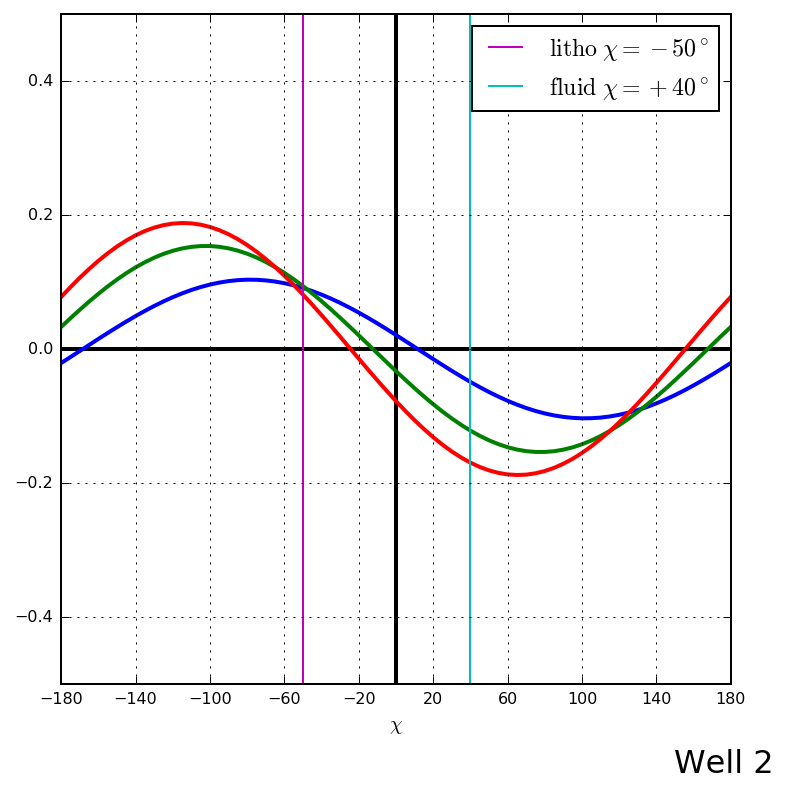

In [13]:
avoproj(w2,2156,25,15,name='Well 2',fluid='oil')

## step 2: load seismic and interpretation

Also see the [seismic data](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_data_in_python.ipynb) and [amplitude extraction](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_amplitude_extraction.ipynb) notebooks for a somewhat more comprehensive overview of using seismic data in Python.

In [14]:
inl=np.arange(1300,1502,2)
crl=np.arange(1500,2002,2)

filename='3d_nearstack.sgy'
f=open(filename, 'rb')
seis,header,trace_headers=segypy.read_segy(f)
ss=seis.reshape(header['ns'],inl.size,crl.size)

lagtime=trace_headers['LagTimeA'][0]*-1
twt=np.arange(lagtime,header['dt']/1e3*header['ns']+lagtime,header['dt']/1e3)

The following lines will load the Top Heimdal interpreted horizon, grid and display it:

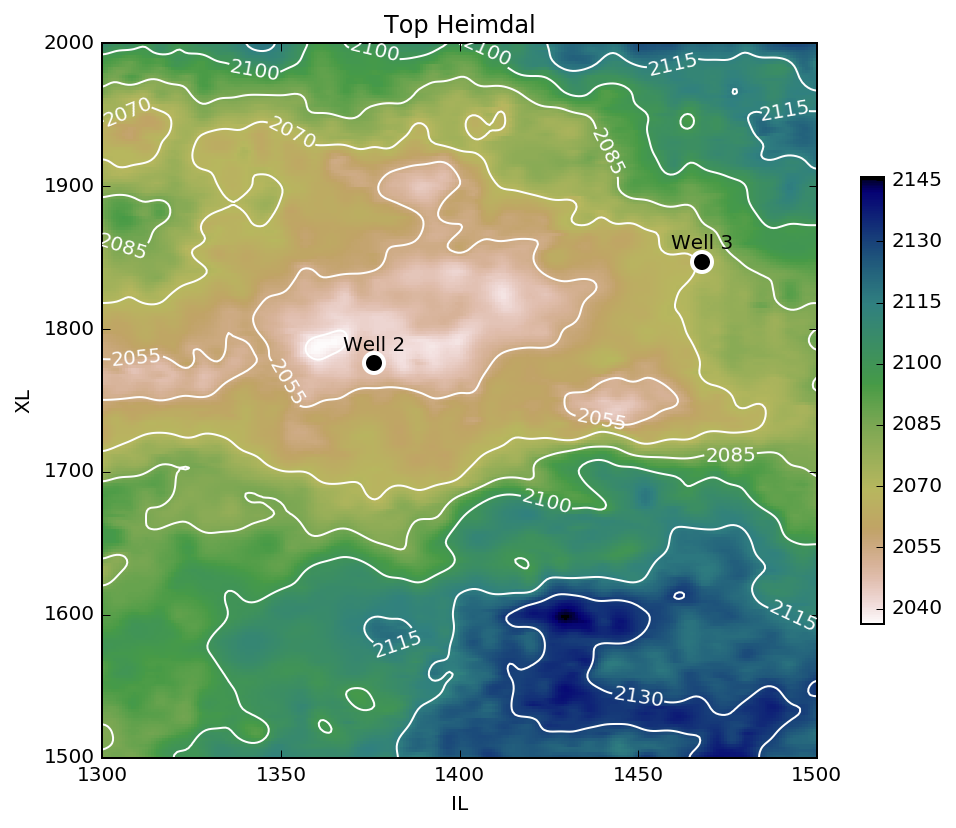

In [15]:
# load data
hrz=np.recfromtxt('Top_Heimdal_subset.txt', names=['il','xl','z'])

# define well locations
well2_il=1376
well2_xl=1776
well3_il=1468
well3_xl=1847

# gridding
xi = np.linspace(inl.min(), inl.max(),250)
yi = np.linspace(crl.min(), crl.max(),250)
X, Y = np.meshgrid(xi, yi)
Z = griddata((hrz['il'], hrz['xl']), hrz['z'], (X,Y), method='cubic')

# smoothing for better-looking contours
import scipy.ndimage as ndimage
Zf = ndimage.gaussian_filter(Z, sigma=2, order=0)

# make the plot
plt.figure(figsize=(8,8))
im0=plt.pcolormesh(X, Y, Z, cmap='gist_earth_r')
CS=plt.contour(X, Y, Zf, 8, colors='w')
plt.clabel(CS, inline=1, fontsize=10, fmt='%.0f')
plt.xlabel('IL'), plt.ylabel('XL')
plt.plot(well2_il, well2_xl, 'ok', ms=10, mew=2, mec='w')
plt.plot(well3_il, well3_xl, 'ok', ms=10, mew=2, mec='w')
plt.text(well2_il, well2_xl+9, 'Well 2', ha='center', fontsize=10)
plt.text(well3_il, well3_xl+9, 'Well 3', ha='center', fontsize=10)
plt.title('Top Heimdal')
plt.colorbar(im0, shrink=0.5)
plt.axes().set_aspect(0.4)

A simple display of an inline with the interpreted horizon superimposed (and here I went for a [little digression](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/top_heimdal_map.ipynb)):

(<matplotlib.text.Text at 0x11931e410>, <matplotlib.text.Text at 0x119c87190>)

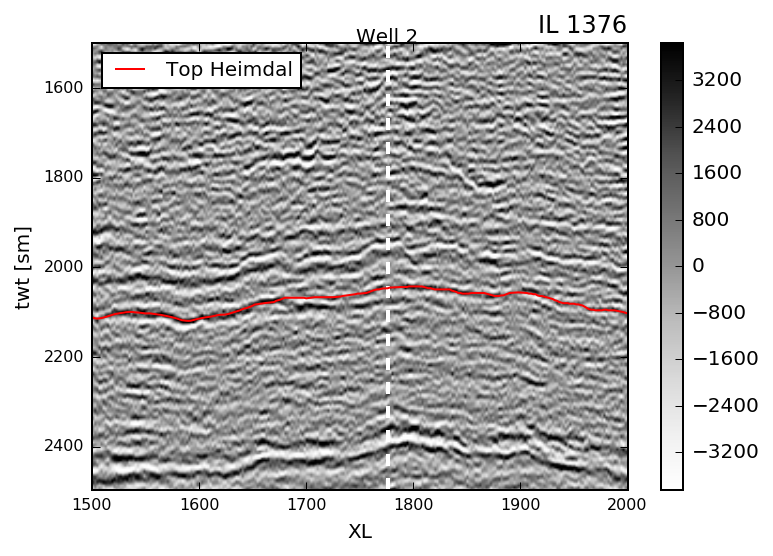

In [16]:
clip=abs(np.percentile(ss, 0.80))

ii=inl.tolist().index(well2_il)
plt.figure()
plt.imshow(ss[:,ii,:],extent=[crl.min(),crl.max(),twt.max(),twt.min()],cmap='Greys',vmax=clip,vmin=-clip,aspect='auto')
plt.axvline(well2_xl,color='w',ls='--',lw=2)
plt.text(well2_xl,twt.min(),'Well 2',ha='center')
plt.plot(hrz[hrz['il']==well2_il]['xl'],hrz[hrz['il']==well2_il]['z'],color='r',label='Top Heimdal')
plt.legend(loc='upper left', fontsize=10)
plt.colorbar(),
plt.xlim(crl.min(),crl.max())
plt.ylim(twt.max(),twt.min())
plt.tick_params(axis='both', which='major', labelsize=8)
plt.title('IL {0}'.format(well2_il),y=1, x=1,ha='right')
plt.ylabel('twt [sm]'), plt.xlabel('XL')

## step 3: AVO attributes

The original dataset also has AVO Intercept and Gradient at Top Heimdal; I will now load and grid them, then make a comparison with Intercept and Gradient calculated in Python to see if they make sense.

In [17]:
ig=np.recfromtxt('RG_3dinv.txt', names=['i','g','z','xl','il'], skip_header=16)

II=griddata((ig['il'],ig['xl']),ig['i'],(X,Y),method='cubic')
GG=griddata((ig['il'],ig['xl']),ig['g'],(X,Y),method='cubic')

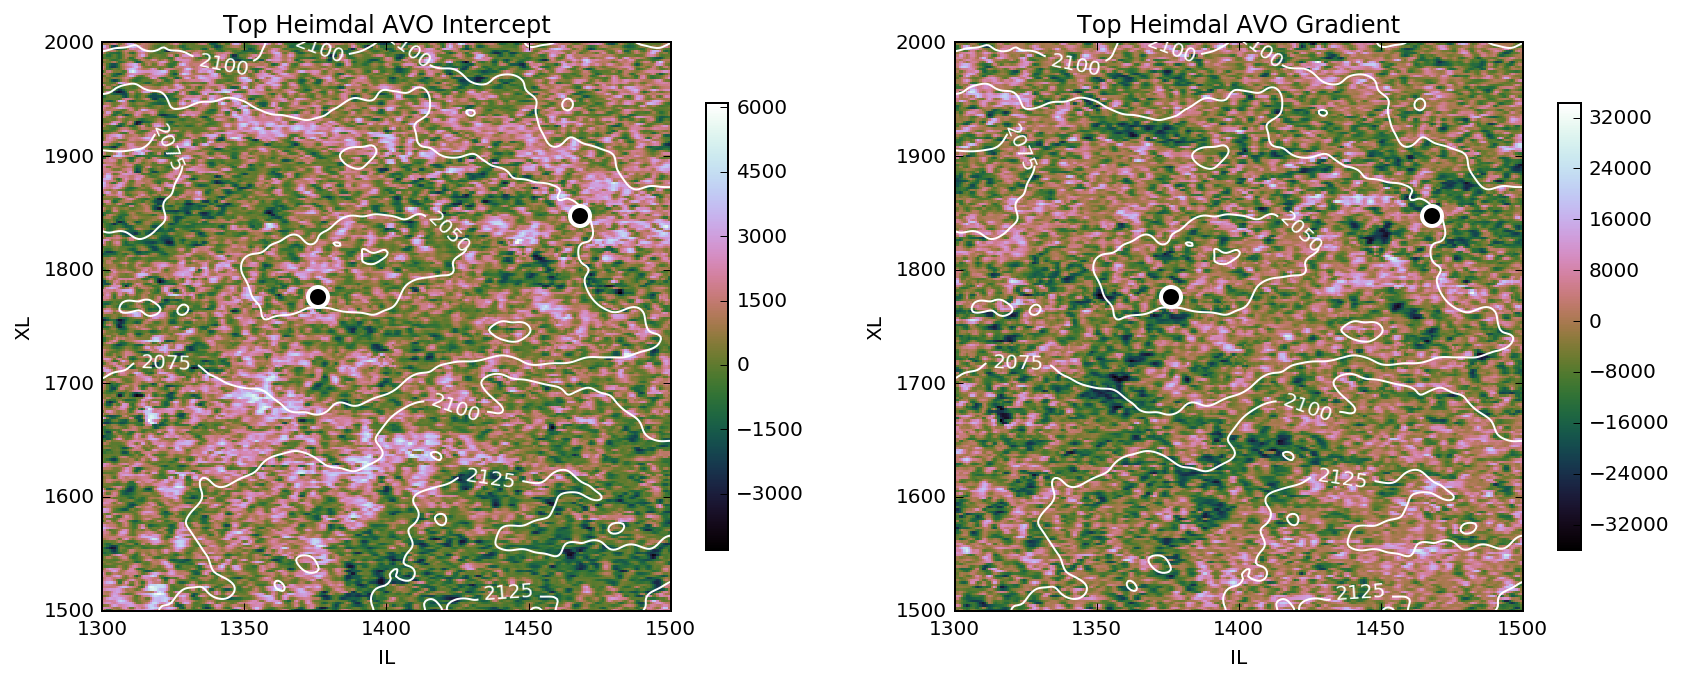

In [18]:
f, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,8))
map0=ax[0].pcolormesh(X, Y, II, cmap='cubehelix')
map1=ax[1].pcolormesh(X, Y, GG, cmap='cubehelix')
ax[0].set_title('Top Heimdal AVO Intercept')
ax[1].set_title('Top Heimdal AVO Gradient')
plt.colorbar(map0, ax=ax[0], shrink=0.5)
plt.colorbar(map1, ax=ax[1], shrink=0.5)
for aa in ax:
    CS=aa.contour(X, Y, Zf, 5, colors='w')
    plt.clabel(CS, inline=1, fontsize=10, fmt='%.0f')
    aa.plot(well2_il, well2_xl, 'ok', ms=10, mew=2, mec='w')
    aa.plot(well3_il, well3_xl, 'ok', ms=10, mew=2, mec='w')
    aa.set_xlabel('IL'), aa.set_ylabel('XL')
    aa.set_aspect(0.4)

### an attempt to calculate AVO attributes in Python

I did this in half an hour after work, and it could be that I missed something very obvious! Anyway, I have all the information (apart from very basic information such as the angles related to Near and Far angle stacks, but we can guesstimate to be around 10 and 30 degrees).

First I load the far angle stack (and copy the seismic dataset I have used so far, `ss` to `near` just to make it clear what I'm dealing with):

In [19]:
near=ss.copy()

filename='3d_farstack.sgy'
f=open(filename, 'rb')
seis,header,trace_headers=segypy.read_segy(f)
far=seis.reshape(header['ns'],inl.size,crl.size)

Then I extract amplitudes at Top Heimdal from the two cubes (see also [this other notebook](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_amplitude_extraction.ipynb) for techniques on amplitude extraction):

In [20]:
from scipy.interpolate import splev, splrep

hrz_extr=np.zeros((hrz.size,5))
twt_finer=np.arange(hrz['z'].min(), hrz['z'].max(),0.1) # creates twt scale at 0.1 ms scale

for i in range(hrz.size):
    ii_idx=inl.tolist().index(hrz['il'][i])
    cc_idx=crl.tolist().index(hrz['xl'][i])
    zz_idx = np.abs(twt-hrz['z'][i]).argmin()

    trace_near = near[:, ii_idx, cc_idx].flatten()
    trace_far = far[:, ii_idx, cc_idx].flatten()
    amp_near = splev(hrz['z'][i], splrep(twt, trace_near))
    amp_far = splev(hrz['z'][i], splrep(twt, trace_far))

    hrz_extr[i,0] = hrz['il'][i]
    hrz_extr[i,1] = hrz['xl'][i]
    hrz_extr[i,2] = hrz['z'][i]
    hrz_extr[i,3] = amp_near
    hrz_extr[i,4] = amp_far

Let's have a look at the Near (`An`) and Far (`Af`) amplitude maps extracted along the Top Heimdal (as usual, first I will grid the data, then display it):

In [21]:
An=griddata((hrz_extr[:,0],hrz_extr[:,1]),hrz_extr[:,3],(X,Y),method='cubic')
Af=griddata((hrz_extr[:,0],hrz_extr[:,1]),hrz_extr[:,4],(X,Y),method='cubic')

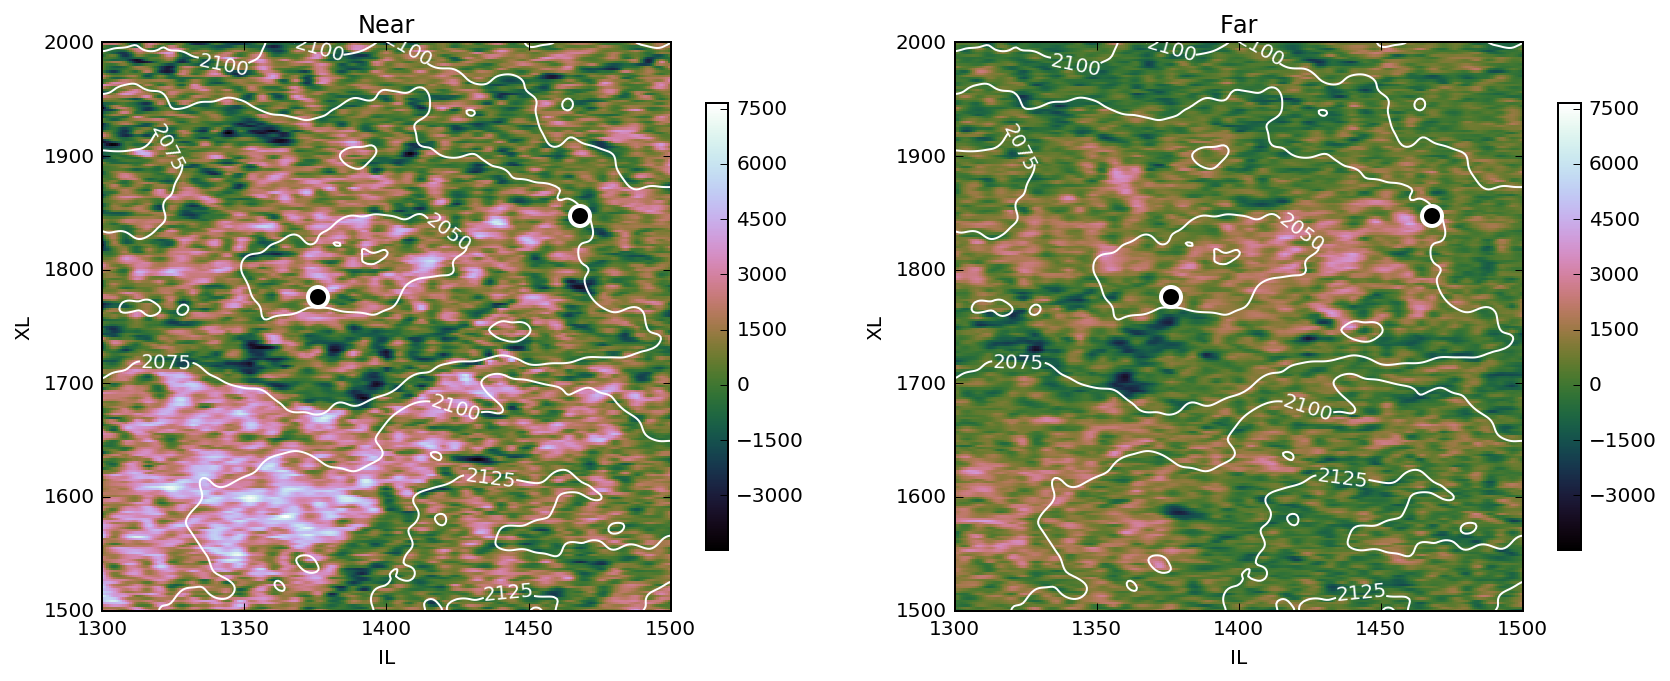

In [22]:
clip_max=np.max(hrz_extr[:,3:4])
clip_min=np.min(hrz_extr[:,3:4])

f, ax = plt.subplots(1,2,figsize=(14,8))
map0 = ax[0].pcolormesh(X, Y, An, vmin=clip_min, vmax=clip_max, cmap='cubehelix')
map1 = ax[1].pcolormesh(X, Y, Af, vmin=clip_min, vmax=clip_max, cmap='cubehelix')
ax[0].set_title('Near')
ax[1].set_title('Far')
for aa in ax.flatten():
    CS=aa.contour(X,Y,Zf,5,colors='w')
    plt.clabel(CS, inline=1, fontsize=10, fmt='%.0f')
    aa.plot(well2_il, well2_xl, 'ok', ms=10, mew=2, mec='w')
    aa.plot(well3_il, well3_xl, 'ok', ms=10, mew=2, mec='w')
    aa.set_xlabel('IL'), aa.set_ylabel('XL')  
    aa.set_aspect(0.4)
    plt.colorbar(map0, ax=aa, shrink=0.5)

To calculate intercept and gradient I will use simple linear regression on near and far amplitudes (i.e., Shuey's equation approach):

In [ ]:
ang_n=10
ang_f=30
x = np.sin(np.deg2rad([ang_n,ang_f]))**2

avo_I = np.zeros(An.size)
avo_G = np.zeros(An.size)

for j in range(An.size):
    y = np.array([An.flatten()[j], Af.flatten()[j]])
    y = np.array([An.flatten()[j], Af.flatten()[j]])
    par = np.polyfit(x,y,1)
    avo_I[j]= par[1]
    avo_G[j]= par[0]
    
avo_I=avo_I.reshape(X.shape)
avo_G=avo_G.reshape(Y.shape)

Uncomment the following to run a little benchmark to see what's fastest, `np.polyfit` or `scipy.stats.linregress`:

_Answer: on a 250x250 grid, `polyfit` does the calculation in 30 seconds, `linregress` in 64 seconds on my work PC which is a Xeon-something Windows 7 machine; on my home computer (Macbook Pro with i5 at 2.6 Ghz and 8Gb RAM) the numbers are 15 and 19 seconds._

In [24]:
y = np.array(((0,1,2,3),(1,2,3,4),(2,4,6,8)))
x = np.tile(np.arange(4), (3,1))
print x
print y

[[0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]]
[[0 1 2 3]
 [1 2 3 4]
 [2 4 6 8]]


In [43]:
# 62500

# x=
# [near near near near]
# [far  far  far  far ]

# y=
# [an  an  an  an]
# [af  af  af  af]


ang_n=10
ang_f=30
x = np.sin(np.deg2rad([ang_n,ang_f]))**2

xx = np.reshape(np.repeat(x,4),(2,4))
yy = np.empty(xx.shape)
yy[0,:] = An.flatten()[:4]
yy[1,:] = Af.flatten()[:4]

print xx
print yy


def multiple_linregress(x, y):
    x_mean = np.mean(x, axis=1, keepdims=True)
    x_norm = x - x_mean
    y_mean = np.mean(y, axis=1, keepdims=True)
    y_norm = y - y_mean
    slope = (np.einsum('ij,ij->i', x_norm, y_norm) /
             np.einsum('ij,ij->i', x_norm, x_norm))
    intercept = y_mean[:, 0] - slope * x_mean[:, 0]

    return np.column_stack((slope, intercept))

print '****** np.polyfit ******'
for j in range(An.size):
    y = np.array([An.flatten()[j], Af.flatten()[j]])
    par = np.polyfit(x,y,1)
    avo_I[j]= par[1]
    avo_G[j]= par[0]   
#     print 'near={0}, far={1}, intercept={2}, gradient={3}'.format(y[0], y[1], par[1], par[0])

print '****** altro ******'


(2, 4)
(2, 4)
[[ 0.03015369  0.03015369  0.03015369  0.03015369]
 [ 0.25        0.25        0.25        0.25      ]]
[[ 2110.7226424   2184.52815962  2266.63875684  2311.48270365]
 [ -728.19741632  -467.9129527   -237.78724535   -43.25628614]]


In [23]:
import time
from scipy import stats

def multiple_linregress(x, y):
    x_mean = np.mean(x, axis=1, keepdims=True)
    x_norm = x - x_mean
    y_mean = np.mean(y, axis=1, keepdims=True)
    y_norm = y - y_mean

    slope = (np.einsum('ij,ij->i', x_norm, y_norm) /
             np.einsum('ij,ij->i', x_norm, x_norm))
    intercept = y_mean[:, 0] - slope * x_mean[:, 0]

    return np.column_stack((slope, intercept))


ang_n=10
ang_f=30
x = np.sin(np.deg2rad([ang_n,ang_f]))**2

avo_I = np.empty(An.size)
avo_G = np.empty(An.size)

print '****** np.polyfit ******'
start = time.time()
for j in range(An.size):
    y = np.array([An.flatten()[j], Af.flatten()[j]])
    par = np.polyfit(x,y,1)
    avo_I[j]= par[1]
    avo_G[j]= par[0]   
#     print 'near={0}, far={1}, intercept={2}, gradient={3}'.format(y[0], y[1], par[1], par[0])
end = time.time()
elapsed = end - start
print 'Time elapsed: {:.2f} seconds.'.format(elapsed)


# np.polynomial.polynomial.polyfit

print '****** stats.linregress ******'
start = time.time()
for j in range(An.size):
    y = np.array([An.flatten()[j], Af.flatten()[j]])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    avo_I[j]= intercept
    avo_G[j]= slope   
#     print 'near={0}, far={1}, intercept={2}, gradient={3}'.format(y[0], y[1], intercept, slope)
end = time.time()
elapsed = end - start
print 'Time elapsed: {:.2f} seconds.'.format(elapsed)

avo_I=avo_I.reshape(X.shape)
avo_G=avo_G.reshape(Y.shape)

****** np.polyfit ******
Time elapsed: 10.36 seconds.
****** stats.linregress ******
Time elapsed: 10.88 seconds.


In [ ]:
x=np.full

In [ ]:
x=np.full

Displaying the original AVO maps with the new ones I have calculated I see similar ranges of values but different pictures; I will investigate a bit further on that, and for the rest of the exercise I will use the original attributes.

In [ ]:
f, ax = plt.subplots(nrows=2,ncols=2,figsize=(12,12))
map0=ax[0,0].pcolormesh(X, Y, II, cmap='cubehelix')
map1=ax[0,1].pcolormesh(X, Y, GG, cmap='cubehelix')
map2=ax[1,0].pcolormesh(X, Y, avo_I, cmap='cubehelix')
map3=ax[1,1].pcolormesh(X, Y, avo_G, cmap='cubehelix')

ax[0,0].set_title('AVO Intercept (original)')
ax[0,1].set_title('AVO Gradient (original)')
ax[1,0].set_title('AVO Intercept (new)')
ax[1,1].set_title('AVO Gradient (new)')

plt.colorbar(map0, ax=ax[0,0], shrink=0.5)
plt.colorbar(map1, ax=ax[0,1], shrink=0.5)
plt.colorbar(map2, ax=ax[1,0], shrink=0.5)
plt.colorbar(map3, ax=ax[1,1], shrink=0.5)

## calculate AVO projection maps

The final maps are calculated with this equation:

$$ R = I * \cos \chi + G * \sin \chi $$

According the analysis previously done on well data, we should have maximum separation between brine and oil at +40 degrees (_AVO fluid projection angle_) and minimum separation at -50 degrees (_AVO lithology projection angle_).

However, it's always best to get a feel for the various combination and "let the data speak", so we can build a little cycle to loop over various projection angles:

In [ ]:
ang=np.linspace(-180,180,9)
f, ax = plt.subplots(3,3, figsize=(14,12))
ax = ax.ravel()
for i,val in enumerate(ang):
    chi=np.deg2rad(val)
    AA = II*np.cos(chi)+GG*np.sin(chi)
    vmin = np.percentile(AA, 1)
    vmax = np.percentile(AA, 99)
    rr=ax[i].pcolormesh(X,Y,AA,vmin=vmin,vmax=vmax,cmap='cubehelix')
    ax[i].set_title('$\chi={0}$'.format(val))
    cb=plt.colorbar(rr, ax=ax[i], shrink=0.75)
    cb.ax.tick_params(labelsize=8)
for aa in ax:
    aa.set_xticklabels([])
    aa.set_yticklabels([])

These would be the projections at the "right" angles:

In [ ]:
chi_litho=np.deg2rad(-50)
chi_fluid=np.deg2rad(40)

AVOL = II*np.cos(chi_litho)+GG*np.sin(chi_litho)
AVOF = II*np.cos(chi_fluid)+GG*np.sin(chi_fluid)

f, ax = plt.subplots(1,2,figsize=(14,8))
map0 = ax[0].pcolormesh(X, Y, AVOL, cmap='cubehelix')
map1 = ax[1].pcolormesh(X, Y, AVOF, cmap='cubehelix')
ax[0].set_title('AVO Lithology Projection')
ax[1].set_title('AVO Fluid Projection')
for aa in ax.flatten():
    CS=aa.contour(X,Y,Zf,5,colors='w')
    plt.clabel(CS, inline=1, fontsize=10, fmt='%.0f')
    aa.plot(well2_il, well2_xl, 'ok', ms=10, mew=2, mec='w')
    aa.plot(well3_il, well3_xl, 'ok', ms=10, mew=2, mec='w')
    aa.set_xlabel('IL'), aa.set_ylabel('XL')  
    aa.set_aspect(0.4)
    plt.colorbar(map0, ax=aa, shrink=0.5)

I don't know if it is worth repeating, but please bear in mind that in this notebook I am not trying to make actual sense of this dataset (I think Avseth et al. have already done everything possible on this data).

If I were to present the results however I would not stop here and what I would do first of all is to compare these maps to the original inputs (Intercept and Gradient), as well as to simple Near and Far amplitude extractions. Then put together some explanation for the visible patterns. But that's another story.